In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tqdm

In [3]:
def prepare_dataset(input_ds):
    # cast datatype to float
    ds = input_ds.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # normalize values
    ds = ds.map(lambda img, target: (img/128. - 1., target))

    # convert target to one-hot vector
    ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [4]:
(train_dataset, test_dataset), ds_info = tfds.load(
    "cifar10", split=["train", "test"], as_supervised=True, with_info=True
)

train_ds = prepare_dataset(train_dataset)
test_ds = prepare_dataset(test_dataset)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteT4MVXD/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteT4MVXD/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


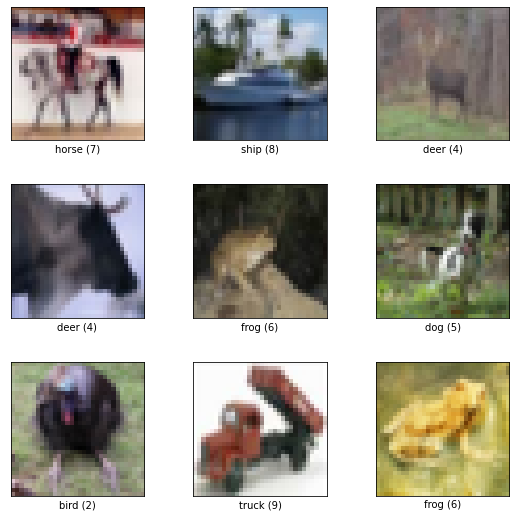

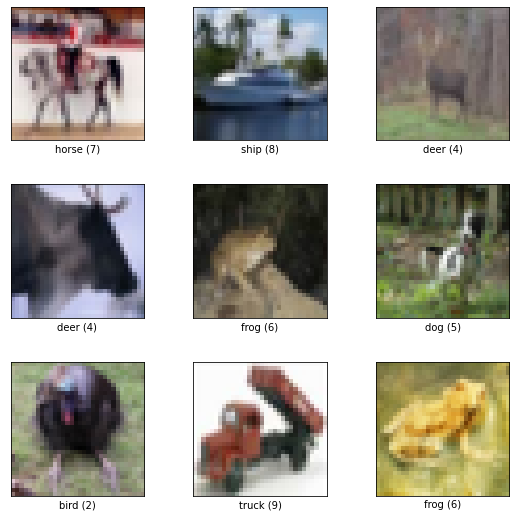

In [5]:
tfds.show_examples(train_dataset, ds_info)

In [6]:
class Cifar10CNN(tf.keras.Model):
    def __init__(self, optimizer, regularization=False, dropout=False, use_label_smoothing=False):
        # initialize superclass
        super().__init__()
        self.optimizer = optimizer

        self.metrics_list = [
            tf.keras.metrics.Mean(name="loss"),
            tf.keras.metrics.CategoricalAccuracy()
        ]


        kernel_regularizer = tf.keras.regularizers.L1() if regularization else None
        label_smoothing = 0.1 if use_label_smoothing else 0.0
        self.dropout = dropout

        self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

        # declare layers
        self.conv1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu", kernel_regularizer=kernel_regularizer)
        if dropout:
            self.dropout1 = tf.keras.layers.Dropout(0.2)
        self.conv2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding="same", activation="relu", kernel_regularizer=kernel_regularizer)
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)


        self.conv3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu", kernel_regularizer=kernel_regularizer)
        if dropout:
            self.dropout2 = tf.keras.layers.Dropout(0.2)
        self.conv4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding="same", activation="relu", kernel_regularizer=kernel_regularizer)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()

        self.out = tf.keras.layers.Dense(10, activation="softmax")


    @tf.function
    def call(self, x, training=False):
        x = self.conv1(x)
        if self.dropout and training:
            x = self.dropout1(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        if self.dropout and training:
            x = self.dropout2(x)
        x = self.conv4(x)
        x = self.global_pool(x)
        x = self.out(x)
        return x


    @property
    def metrics(self):
        return self.metrics_list


    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()


    def train_step(self, data):
        img, label = data

        with tf.GradientTape() as tape:
            output = self(img, training=True)
            loss = self.loss_function(label, output)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,
                                           self.trainable_variables))

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(output, label)

        return {m.name: m.result() for m in self.metrics}


    def test_step(self, data):
        img, label = data
        output = self(img, training=False)
        loss = self.loss_function(label, output)

        self.metrics[0].update_state(loss)
        self.metrics[1].update_state(output, label)

        return {f"val_{m.name}": m.result() for m in self.metrics}

In [7]:
def train_model(model, train_ds, test_ds):
    train_metrics = []
    val_metrics = []

    for e in range(25):
        for data in tqdm.tqdm(train_ds):
            metrics = model.train_step(data)
        
        for name, value in metrics.items():
            print(f"Epoch {e}: {name}: {value}")

        train_metrics.append(metrics)
        model.reset_metrics()

        for data in test_ds:
            metrics = model.test_step(data)
        
        for name, value in metrics.items():
            print(f"Epoch {e}: {name}: {value}")
        
        val_metrics.append(metrics)
        model.reset_metrics()
    
    return (train_metrics, val_metrics)

In [9]:
optimizer = tf.keras.optimizers.Adam()

model = Cifar10CNN(optimizer, regularization=False, dropout=False, use_label_smoothing=True)

train_metrics, val_metrics = train_model(model, train_ds, test_ds)

100%|██████████| 1563/1563 [00:27<00:00, 57.50it/s]


Epoch 0: loss: 1.8316570520401
Epoch 0: categorical_accuracy: 0.37117999792099
Epoch 0: val_loss: 1.637285828590393
Epoch 0: val_categorical_accuracy: 0.47870001196861267


100%|██████████| 1563/1563 [00:25<00:00, 61.25it/s]


Epoch 1: loss: 1.5874437093734741
Epoch 1: categorical_accuracy: 0.5080000162124634
Epoch 1: val_loss: 1.5445624589920044
Epoch 1: val_categorical_accuracy: 0.5393000245094299


100%|██████████| 1563/1563 [00:26<00:00, 58.80it/s]


Epoch 2: loss: 1.4663105010986328
Epoch 2: categorical_accuracy: 0.5685399770736694
Epoch 2: val_loss: 1.4022811651229858
Epoch 2: val_categorical_accuracy: 0.5960999727249146


100%|██████████| 1563/1563 [00:26<00:00, 58.49it/s]


Epoch 3: loss: 1.3859409093856812
Epoch 3: categorical_accuracy: 0.6093599796295166
Epoch 3: val_loss: 1.3504638671875
Epoch 3: val_categorical_accuracy: 0.6266000270843506


100%|██████████| 1563/1563 [00:25<00:00, 60.90it/s]


Epoch 4: loss: 1.3310034275054932
Epoch 4: categorical_accuracy: 0.639519989490509
Epoch 4: val_loss: 1.3129286766052246
Epoch 4: val_categorical_accuracy: 0.6488999724388123


100%|██████████| 1563/1563 [00:25<00:00, 60.54it/s]


Epoch 5: loss: 1.289971113204956
Epoch 5: categorical_accuracy: 0.6603000164031982
Epoch 5: val_loss: 1.2899490594863892
Epoch 5: val_categorical_accuracy: 0.6563000082969666


100%|██████████| 1563/1563 [00:25<00:00, 60.26it/s]


Epoch 6: loss: 1.2572299242019653
Epoch 6: categorical_accuracy: 0.6764400005340576
Epoch 6: val_loss: 1.2858389616012573
Epoch 6: val_categorical_accuracy: 0.6599000096321106


100%|██████████| 1563/1563 [00:40<00:00, 38.17it/s]


Epoch 7: loss: 1.2314954996109009
Epoch 7: categorical_accuracy: 0.6897600293159485
Epoch 7: val_loss: 1.2518795728683472
Epoch 7: val_categorical_accuracy: 0.6822999715805054


100%|██████████| 1563/1563 [00:25<00:00, 61.15it/s]


Epoch 8: loss: 1.2057316303253174
Epoch 8: categorical_accuracy: 0.7036600112915039
Epoch 8: val_loss: 1.2372183799743652
Epoch 8: val_categorical_accuracy: 0.6830999851226807


100%|██████████| 1563/1563 [00:25<00:00, 60.98it/s]


Epoch 9: loss: 1.1813629865646362
Epoch 9: categorical_accuracy: 0.7148799896240234
Epoch 9: val_loss: 1.1955959796905518
Epoch 9: val_categorical_accuracy: 0.7123000025749207


100%|██████████| 1563/1563 [00:40<00:00, 38.17it/s]


Epoch 10: loss: 1.1590467691421509
Epoch 10: categorical_accuracy: 0.7266200184822083
Epoch 10: val_loss: 1.172594666481018
Epoch 10: val_categorical_accuracy: 0.7159000039100647


100%|██████████| 1563/1563 [00:25<00:00, 61.09it/s]


Epoch 11: loss: 1.1440123319625854
Epoch 11: categorical_accuracy: 0.7340999841690063
Epoch 11: val_loss: 1.1558079719543457
Epoch 11: val_categorical_accuracy: 0.7235000133514404


100%|██████████| 1563/1563 [00:25<00:00, 61.53it/s]


Epoch 12: loss: 1.1269757747650146
Epoch 12: categorical_accuracy: 0.7434399724006653
Epoch 12: val_loss: 1.2004826068878174
Epoch 12: val_categorical_accuracy: 0.7046999931335449


100%|██████████| 1563/1563 [00:25<00:00, 61.48it/s]


Epoch 13: loss: 1.1097443103790283
Epoch 13: categorical_accuracy: 0.753000020980835
Epoch 13: val_loss: 1.1541579961776733
Epoch 13: val_categorical_accuracy: 0.7325000166893005


100%|██████████| 1563/1563 [00:25<00:00, 61.50it/s]


Epoch 14: loss: 1.0951306819915771
Epoch 14: categorical_accuracy: 0.7607399821281433
Epoch 14: val_loss: 1.1260218620300293
Epoch 14: val_categorical_accuracy: 0.7443000078201294


100%|██████████| 1563/1563 [00:25<00:00, 61.07it/s]


Epoch 15: loss: 1.0809253454208374
Epoch 15: categorical_accuracy: 0.7676600217819214
Epoch 15: val_loss: 1.120667576789856
Epoch 15: val_categorical_accuracy: 0.7477999925613403


100%|██████████| 1563/1563 [00:25<00:00, 61.25it/s]


Epoch 16: loss: 1.0673046112060547
Epoch 16: categorical_accuracy: 0.7734400033950806
Epoch 16: val_loss: 1.123235821723938
Epoch 16: val_categorical_accuracy: 0.744700014591217


100%|██████████| 1563/1563 [00:26<00:00, 59.37it/s]


Epoch 17: loss: 1.0557993650436401
Epoch 17: categorical_accuracy: 0.7806599736213684
Epoch 17: val_loss: 1.1024240255355835
Epoch 17: val_categorical_accuracy: 0.7530999779701233


100%|██████████| 1563/1563 [00:25<00:00, 61.11it/s]


Epoch 18: loss: 1.0454462766647339
Epoch 18: categorical_accuracy: 0.7859399914741516
Epoch 18: val_loss: 1.1064485311508179
Epoch 18: val_categorical_accuracy: 0.7504000067710876


100%|██████████| 1563/1563 [00:25<00:00, 60.50it/s]


Epoch 19: loss: 1.0343531370162964
Epoch 19: categorical_accuracy: 0.7923399806022644
Epoch 19: val_loss: 1.1104793548583984
Epoch 19: val_categorical_accuracy: 0.757099986076355


100%|██████████| 1563/1563 [00:25<00:00, 60.98it/s]


Epoch 20: loss: 1.0262303352355957
Epoch 20: categorical_accuracy: 0.7966200113296509
Epoch 20: val_loss: 1.0914485454559326
Epoch 20: val_categorical_accuracy: 0.760699987411499


100%|██████████| 1563/1563 [00:25<00:00, 61.31it/s]


Epoch 21: loss: 1.0180540084838867
Epoch 21: categorical_accuracy: 0.799839973449707
Epoch 21: val_loss: 1.107067346572876
Epoch 21: val_categorical_accuracy: 0.7537000179290771


100%|██████████| 1563/1563 [00:25<00:00, 61.30it/s]


Epoch 22: loss: 1.0078343152999878
Epoch 22: categorical_accuracy: 0.8067799806594849
Epoch 22: val_loss: 1.0728510618209839
Epoch 22: val_categorical_accuracy: 0.7702000141143799


100%|██████████| 1563/1563 [00:25<00:00, 61.66it/s]


Epoch 23: loss: 1.0005567073822021
Epoch 23: categorical_accuracy: 0.8094599843025208
Epoch 23: val_loss: 1.0936293601989746
Epoch 23: val_categorical_accuracy: 0.7587000131607056


100%|██████████| 1563/1563 [00:25<00:00, 61.97it/s]


Epoch 24: loss: 0.993206262588501
Epoch 24: categorical_accuracy: 0.8141199946403503
Epoch 24: val_loss: 1.069048523902893
Epoch 24: val_categorical_accuracy: 0.7724000215530396


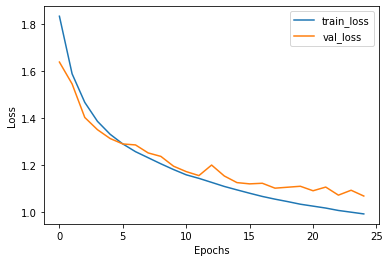

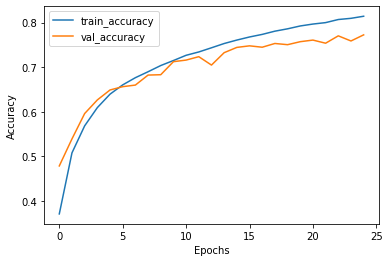

In [13]:
train_loss = [train_metric["loss"] for train_metric in train_metrics]
train_accuracy = [train_metric["categorical_accuracy"] for train_metric in train_metrics]
val_loss = [val_metric["val_loss"] for val_metric in val_metrics]
val_accuracy = [val_metric["val_categorical_accuracy"] for val_metric in val_metrics]

plt.figure()
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(train_accuracy, label="train_accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
